In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import numpy as np

Load data

In [6]:
df = pd.read_csv("/Users/nikita/Desktop/Test Assigment tabby/data/dataset.csv", names=['id', 'sample_date', 'target'] + [f"feature_{i}" for i in range(160)])

Delete useless columm

In [7]:
df = df.drop(columns=["id"])


So let's start with features include NaN's. 

In [8]:
df.isna().mean()[df.isna().mean() > 0].shape

(58,)

We see that these features is a lot. But there exist features with percent of NaN more 50%. I think we can del these features because we don't know source and domain data.

In [9]:
cols_for_del = df.isna().mean()[df.isna().mean() > 0.5].index

Let's continue with other NaN's features

In [10]:
nan_cols = df.isna().mean()[(df.isna().mean() <= 0.5) & (df.isna().mean() > 0)].index


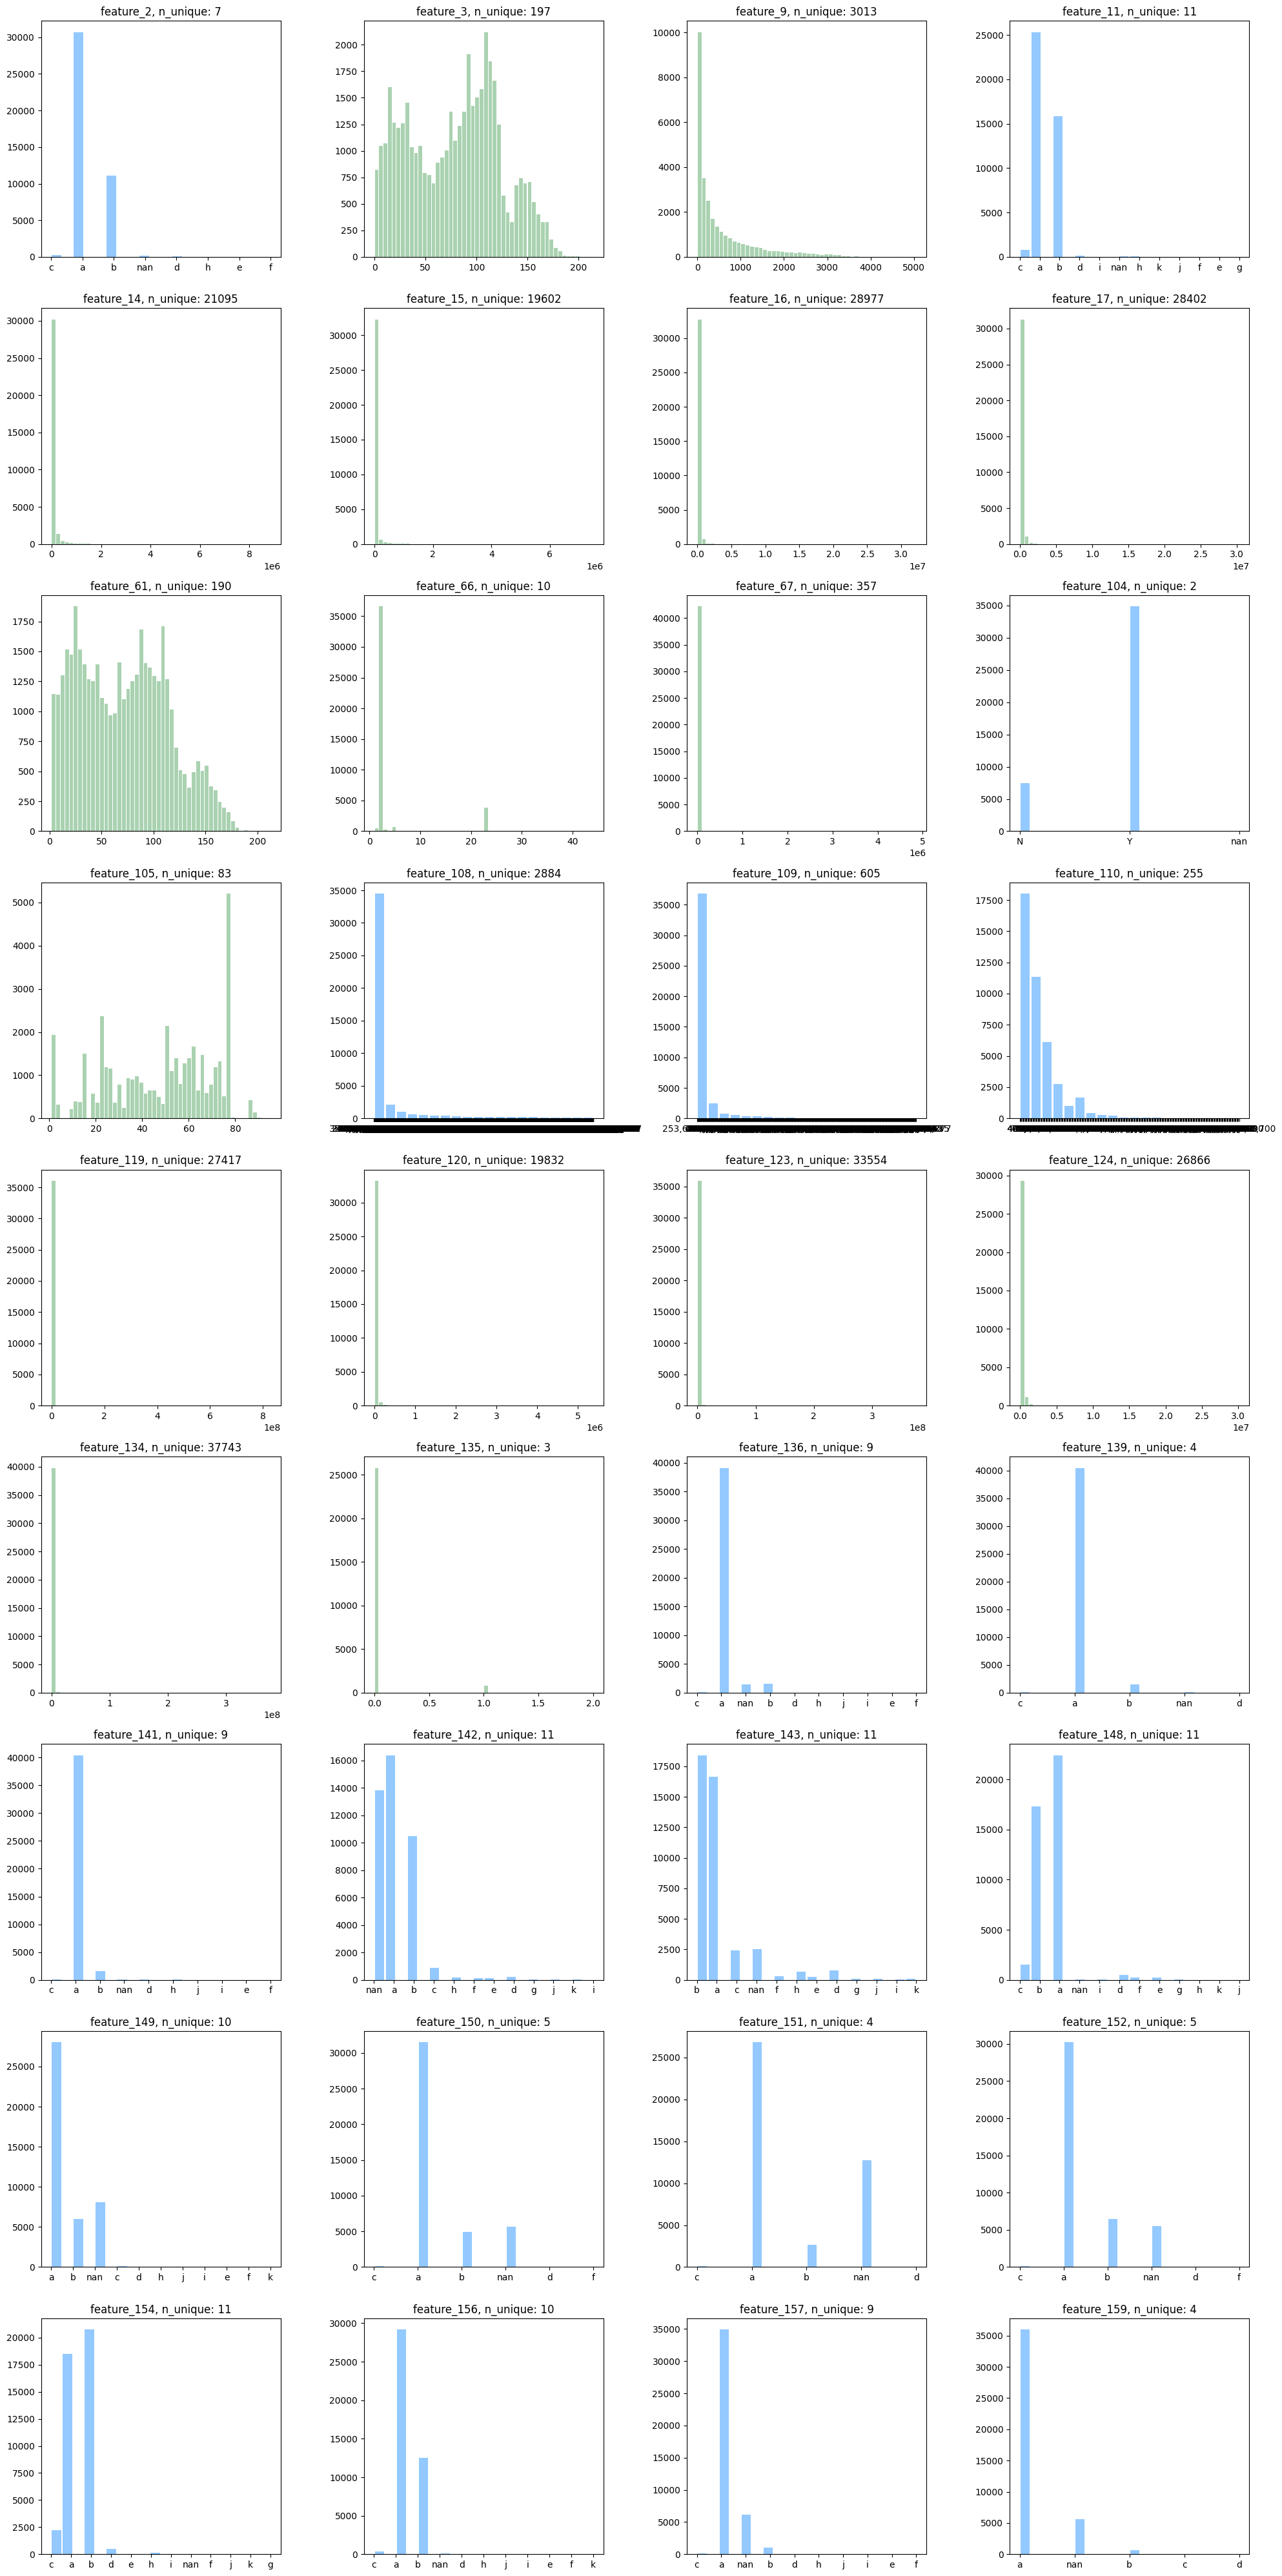

In [11]:
fig, axs = plt.subplots(9, 4, figsize=(20, 40))
axs = axs.ravel()

for idx, col in enumerate(nan_cols):
    if df[col].dtype == 'float':
        axs[idx].hist(df[col], bins=50, color='#86bf91', alpha=0.7, rwidth=0.85)
        axs[idx].set_title(f'{col}, n_unique: {df[col].nunique()}')  # Set the title for each subplot
    else:
        axs[idx].hist(df[col].astype("str"), bins=20, color='#66b3ff', alpha=0.7, rwidth=0.85)
        axs[idx].set_title(f'{col}, n_unique: {df[col].nunique()}')  # Set the title for each subplot

plt.tight_layout()
plt.show()


After analyse histogramms above, I think do following actions:
1. NaN values from columns with low number of unique values we replace to the most frequent value
2. For other columns we use median value
3. For feature with distribution looks like as Exponential we can using log

Let's continue with features without NaN

In [12]:
wh_nan_cols = df.isna().mean()[df.isna().mean() == 0].index[2:]

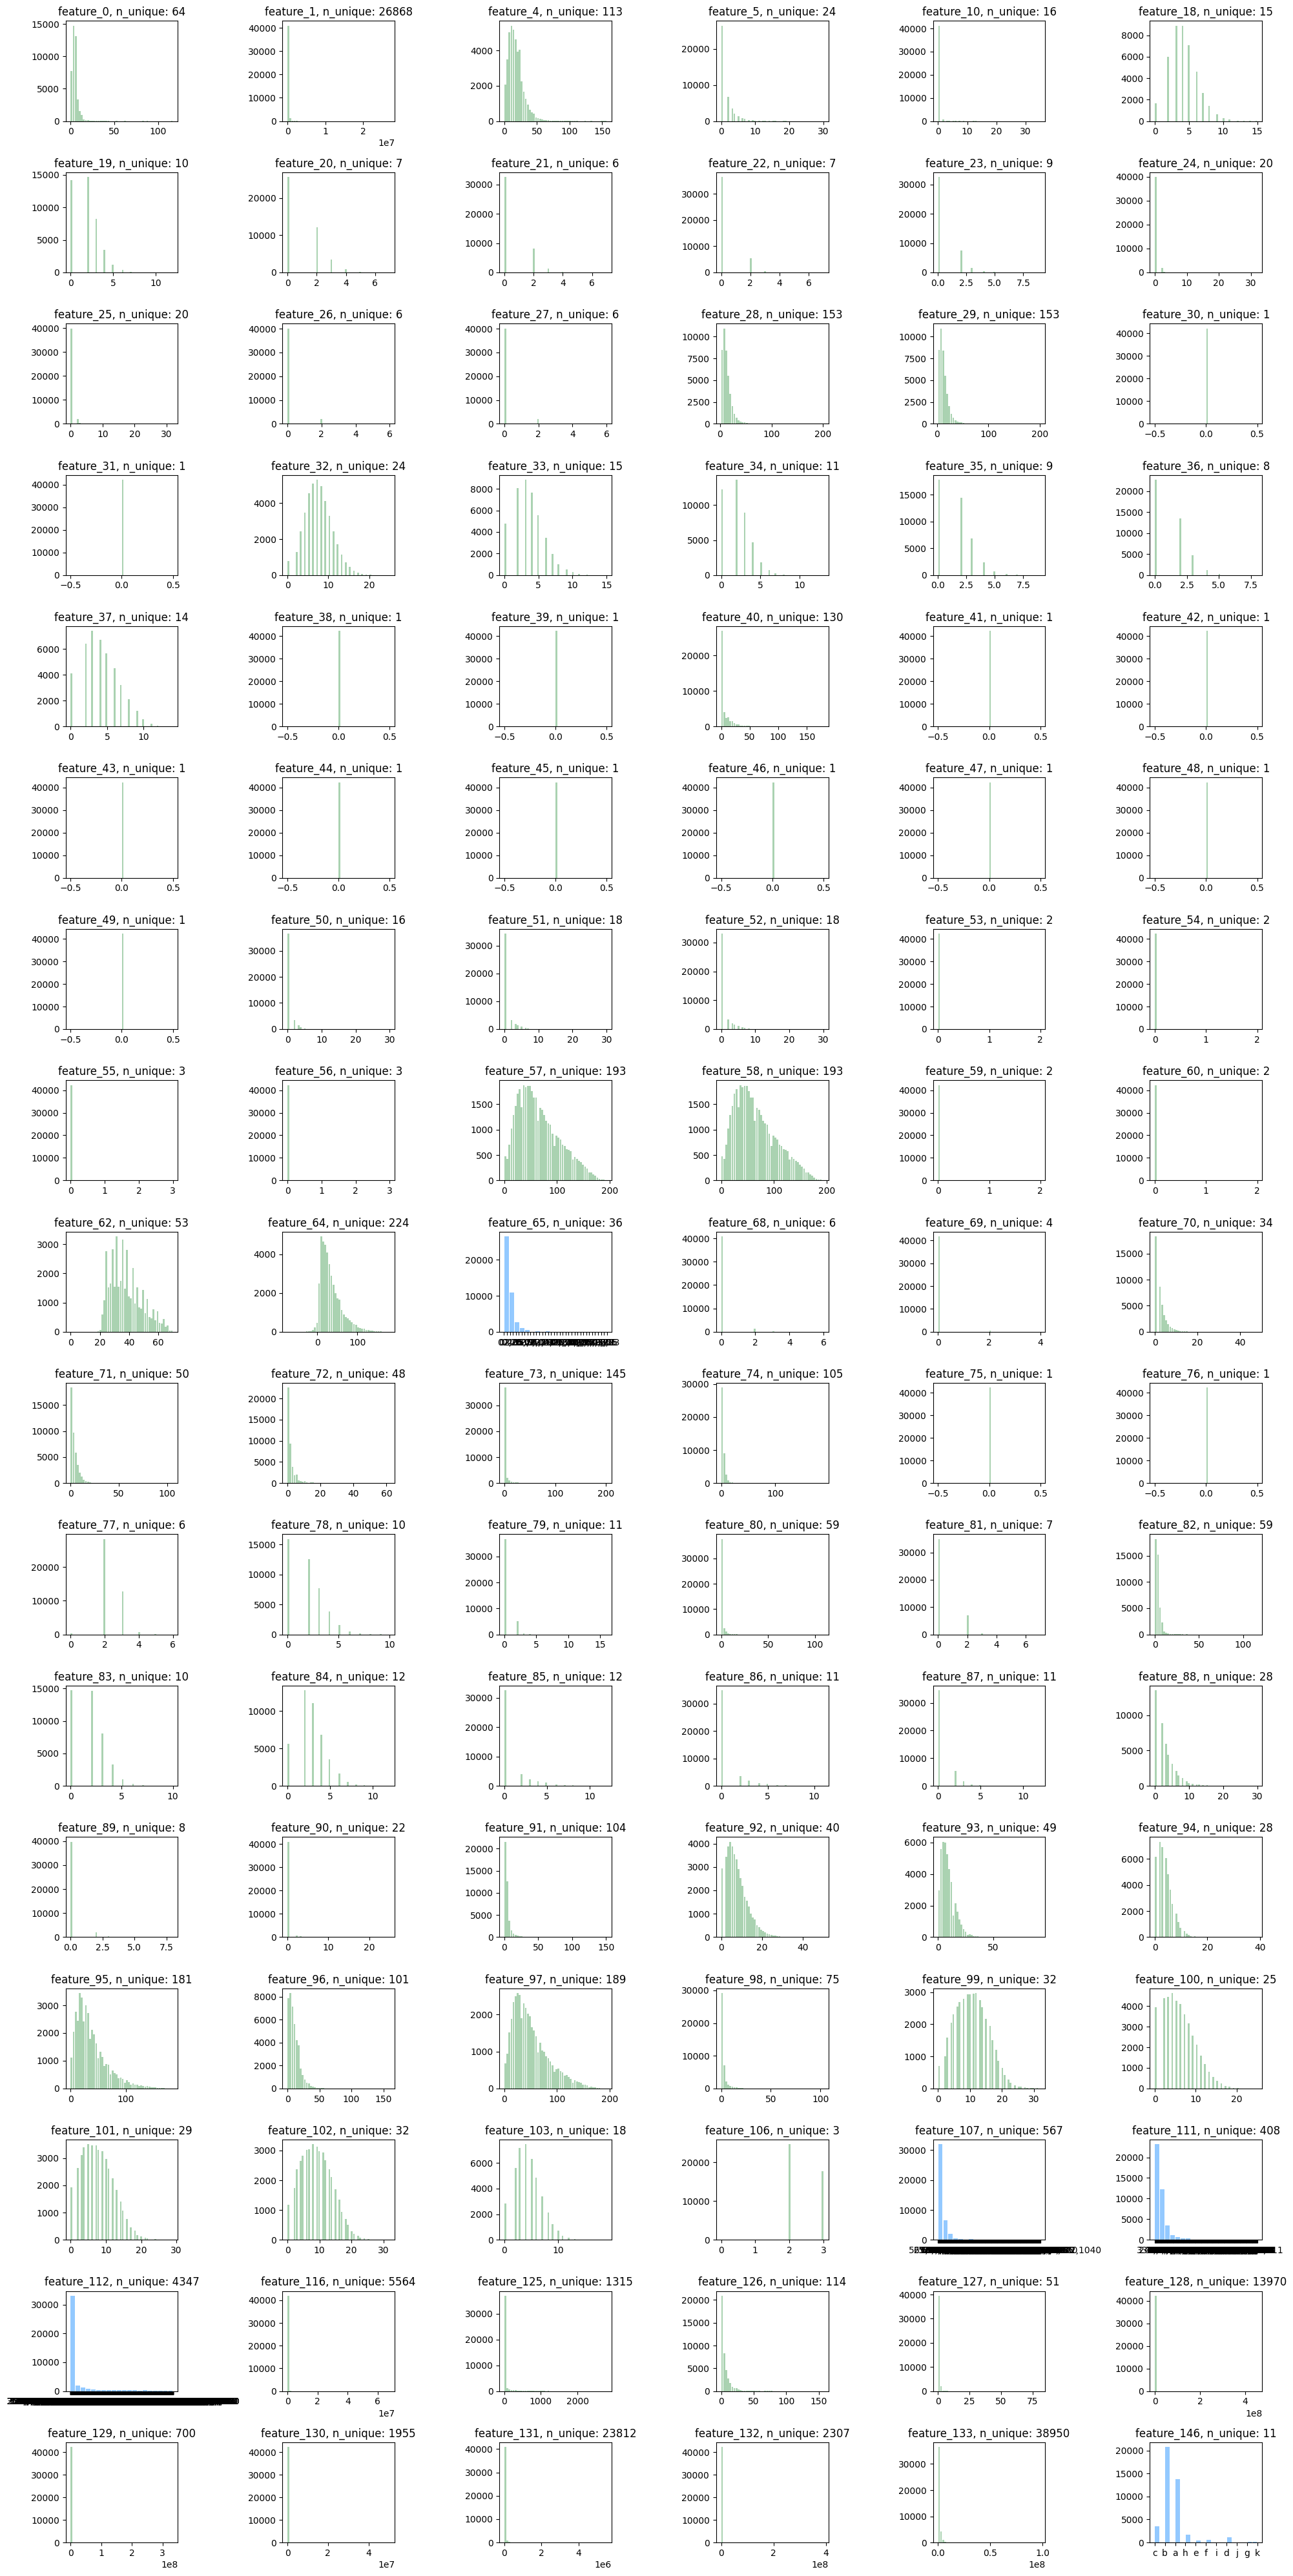

In [13]:
fig, axs = plt.subplots(17, 6, figsize=(20, 40))
axs = axs.ravel() 

for idx, col in enumerate(wh_nan_cols):
    if df[col].dtype == 'float':
        axs[idx].hist(df[col], bins=50, color='#86bf91', alpha=0.7, rwidth=0.85)
        axs[idx].set_title(f'{col}, n_unique: {df[col].nunique()}')  
    else:
        axs[idx].hist(df[col].astype("str"), bins=20, color='#66b3ff', alpha=0.7, rwidth=0.85)
        axs[idx].set_title(f'{col}, n_unique: {df[col].nunique()}')  

plt.tight_layout()
plt.show()

1. For feature with distribution looks like as Exponential we can using log
2. Delete features with count of unique values equals 1


Let's analyse target 

In [14]:
df['target'].value_counts()

target
0.0    38193
1.0     4080
Name: count, dtype: int64

We faced with unbalanced data. We can try oversamplig, undersampling or technuqies like SMOTE. We add this like hyperparameter 

Let's del NaN and transform some columns

In [15]:
num_useless_cols = [76, 75, 49, 48, 47, 46, 45, 44, 43, 42, 41, 39, 38, 31, 30]
useless_cols = [f"feature_{num}" for num in num_useless_cols]
df = df.drop(columns=cols_for_del.tolist() + useless_cols)
num_cat_cols = [2, 11, 104, 66, 3, 9, 141, 142, 143, 136, 139, 135, 148, 149, 150, 151, 152, 154, 156, 159, 157, 65, 107, 112, 111, 146, 108, 109, 110]
cat_cols = [f"feature_{num}" for num in num_cat_cols]
other_cols = list(set(nan_cols) - set(cat_cols))


In [16]:
for col in tqdm.tqdm(cat_cols):
    df[col] = df[col].fillna(df[col].value_counts().idxmax())

for col in tqdm.tqdm(other_cols):
    df[col] = df[col].fillna(df[col].median())


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 299.47it/s]


In [17]:
num_exp_cols = [9, 14, 15, 16, 17, 120, 123, 124, 119, 123, 124, 134, 135, 133]
exp_cols = [f"feature_{num}" for num in num_exp_cols]
delta = 0.1
for col in tqdm.tqdm(exp_cols):
    df[col] = np.log(df[col] + delta)

100%|██████████| 14/14 [00:00<00:00, 770.80it/s]


For encode features with categorical values. If count of unique values is small we use ```OHE```, otherwise we frequency encoder. We'll do it in ```DataTransformer```

<Axes: >

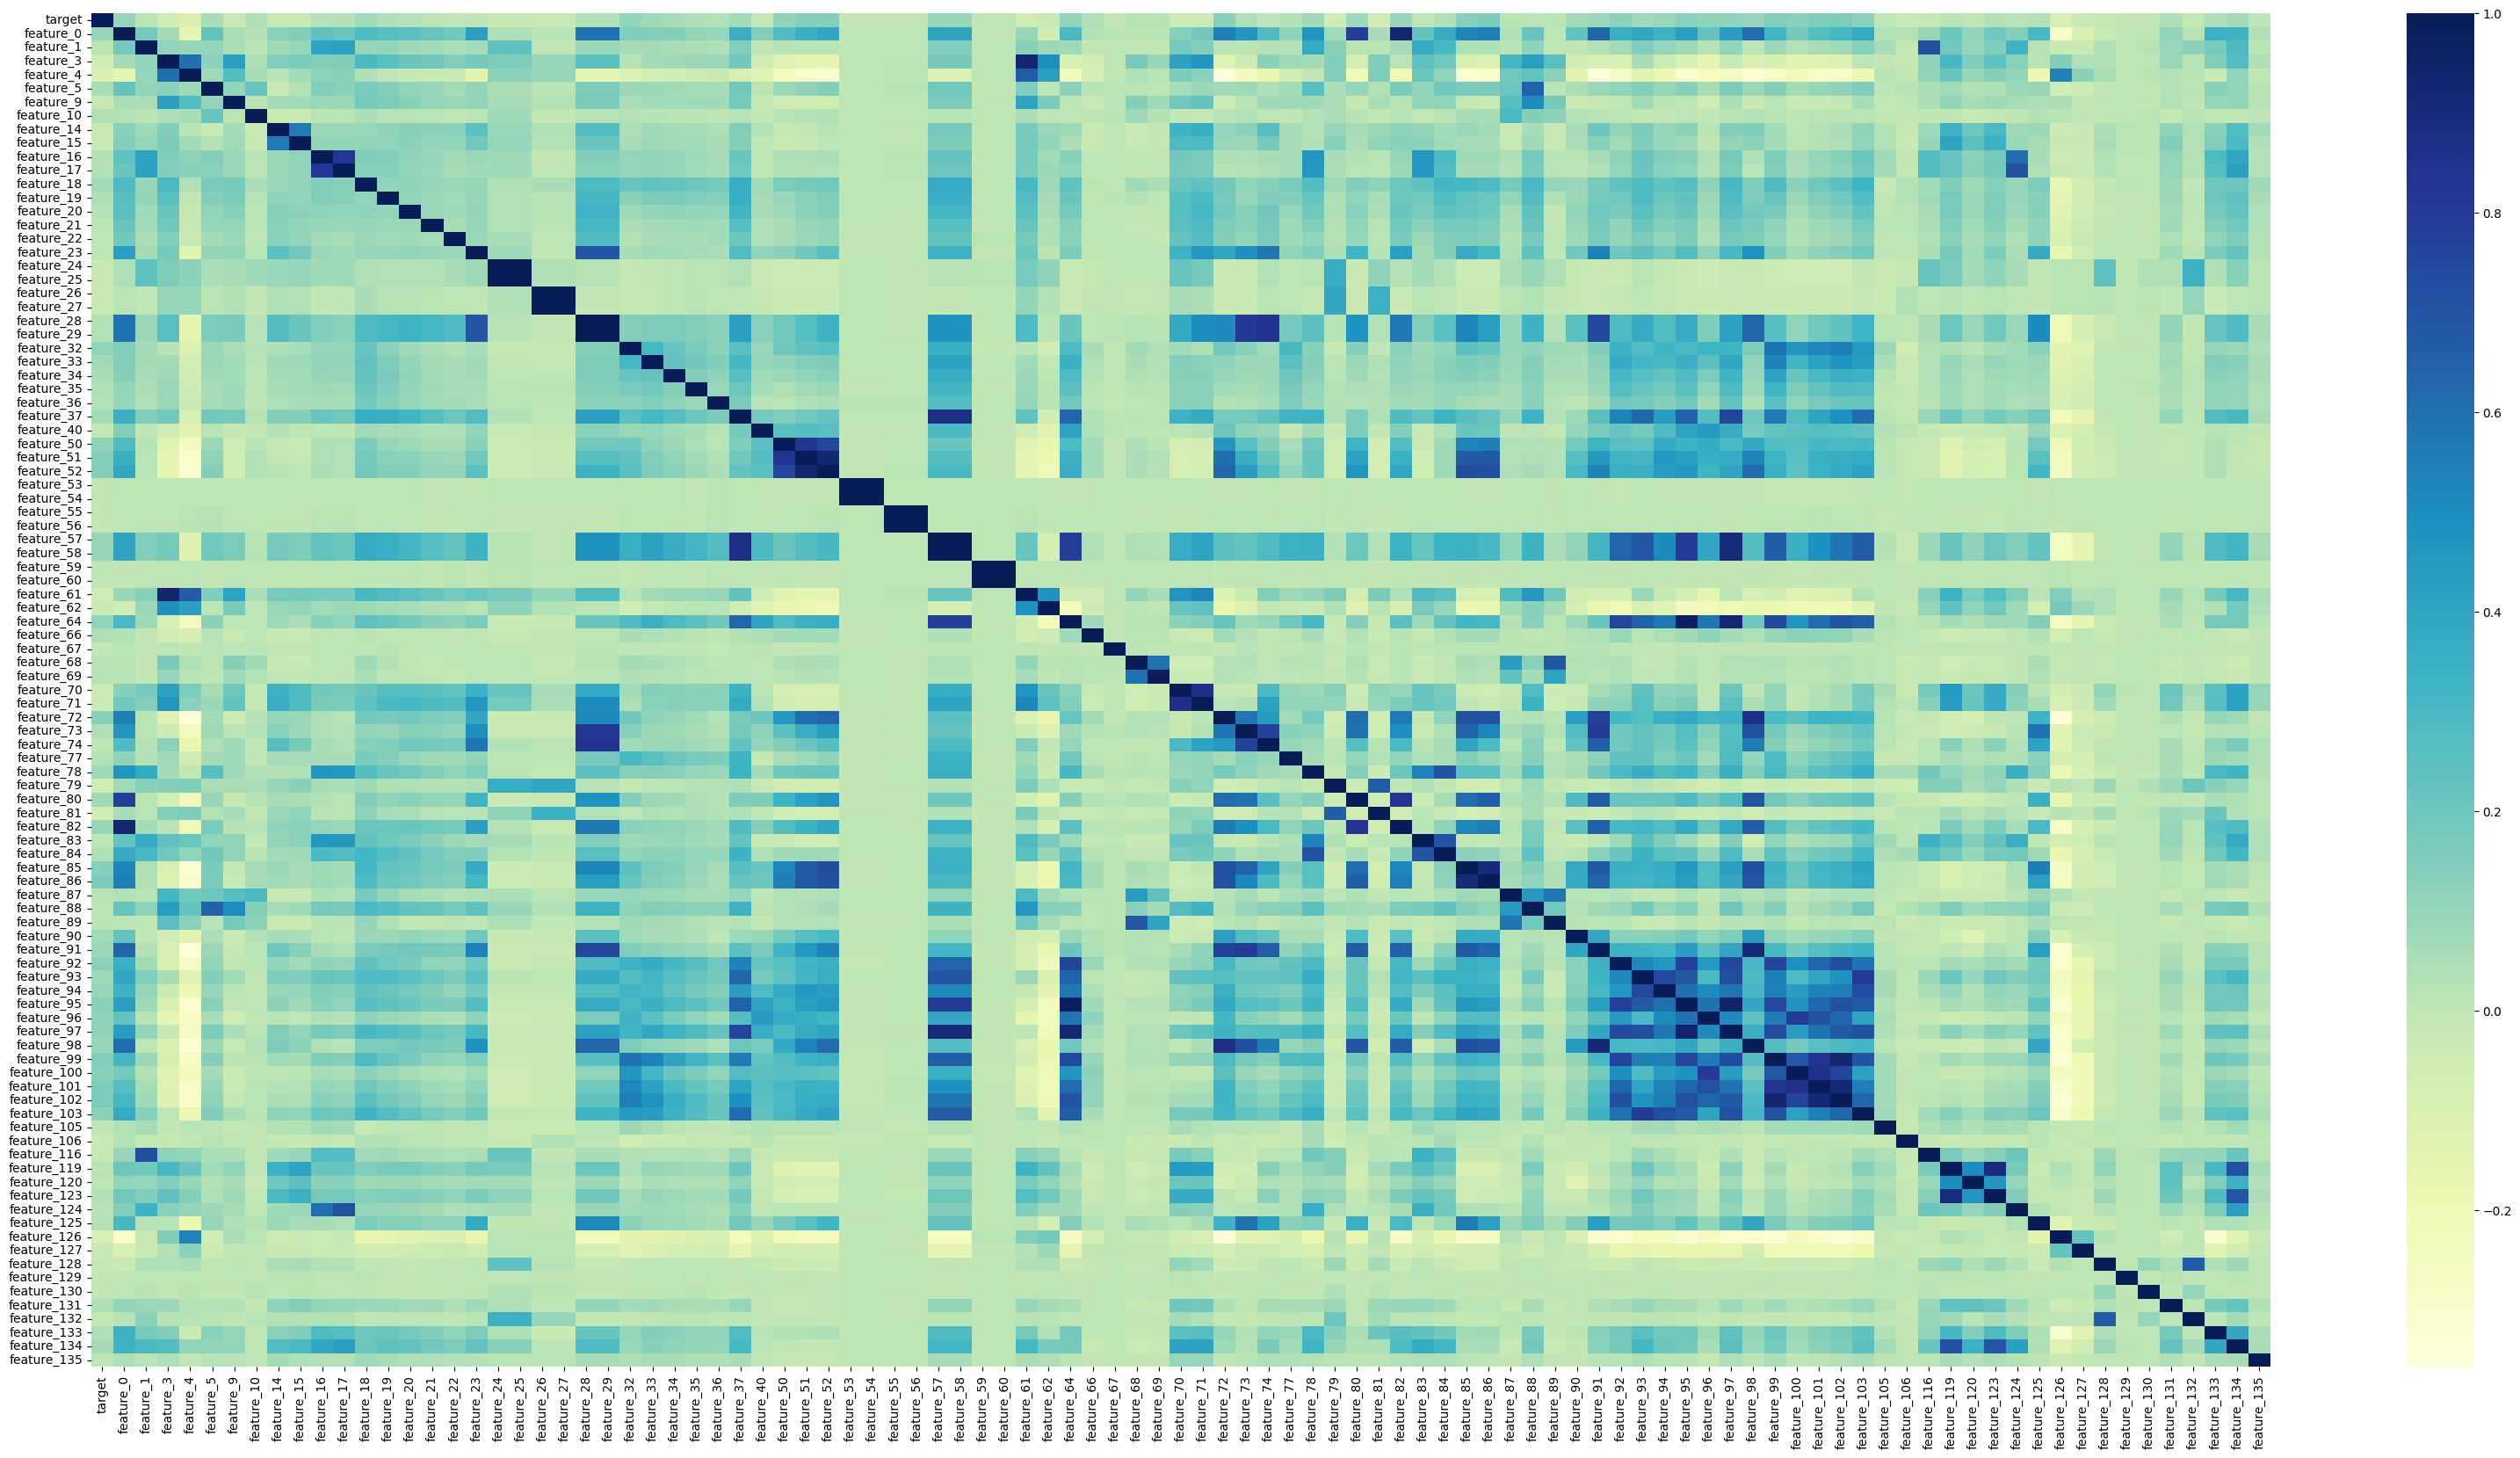

In [18]:
plt.figure(figsize=(40, 20))
corr_matrix = df.select_dtypes(exclude=['object']).corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")


See high-corelated features. In case of creating linear model it can be problem

1) 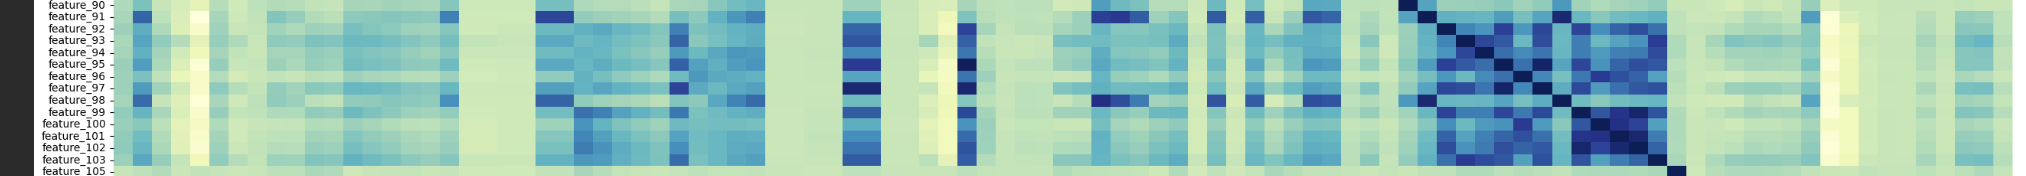
2) 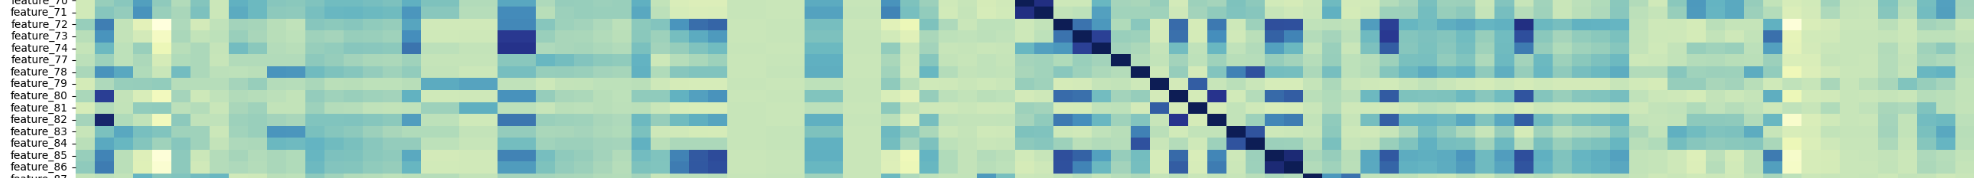

In [19]:

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]


Delete part of high-correlated features

<Axes: >

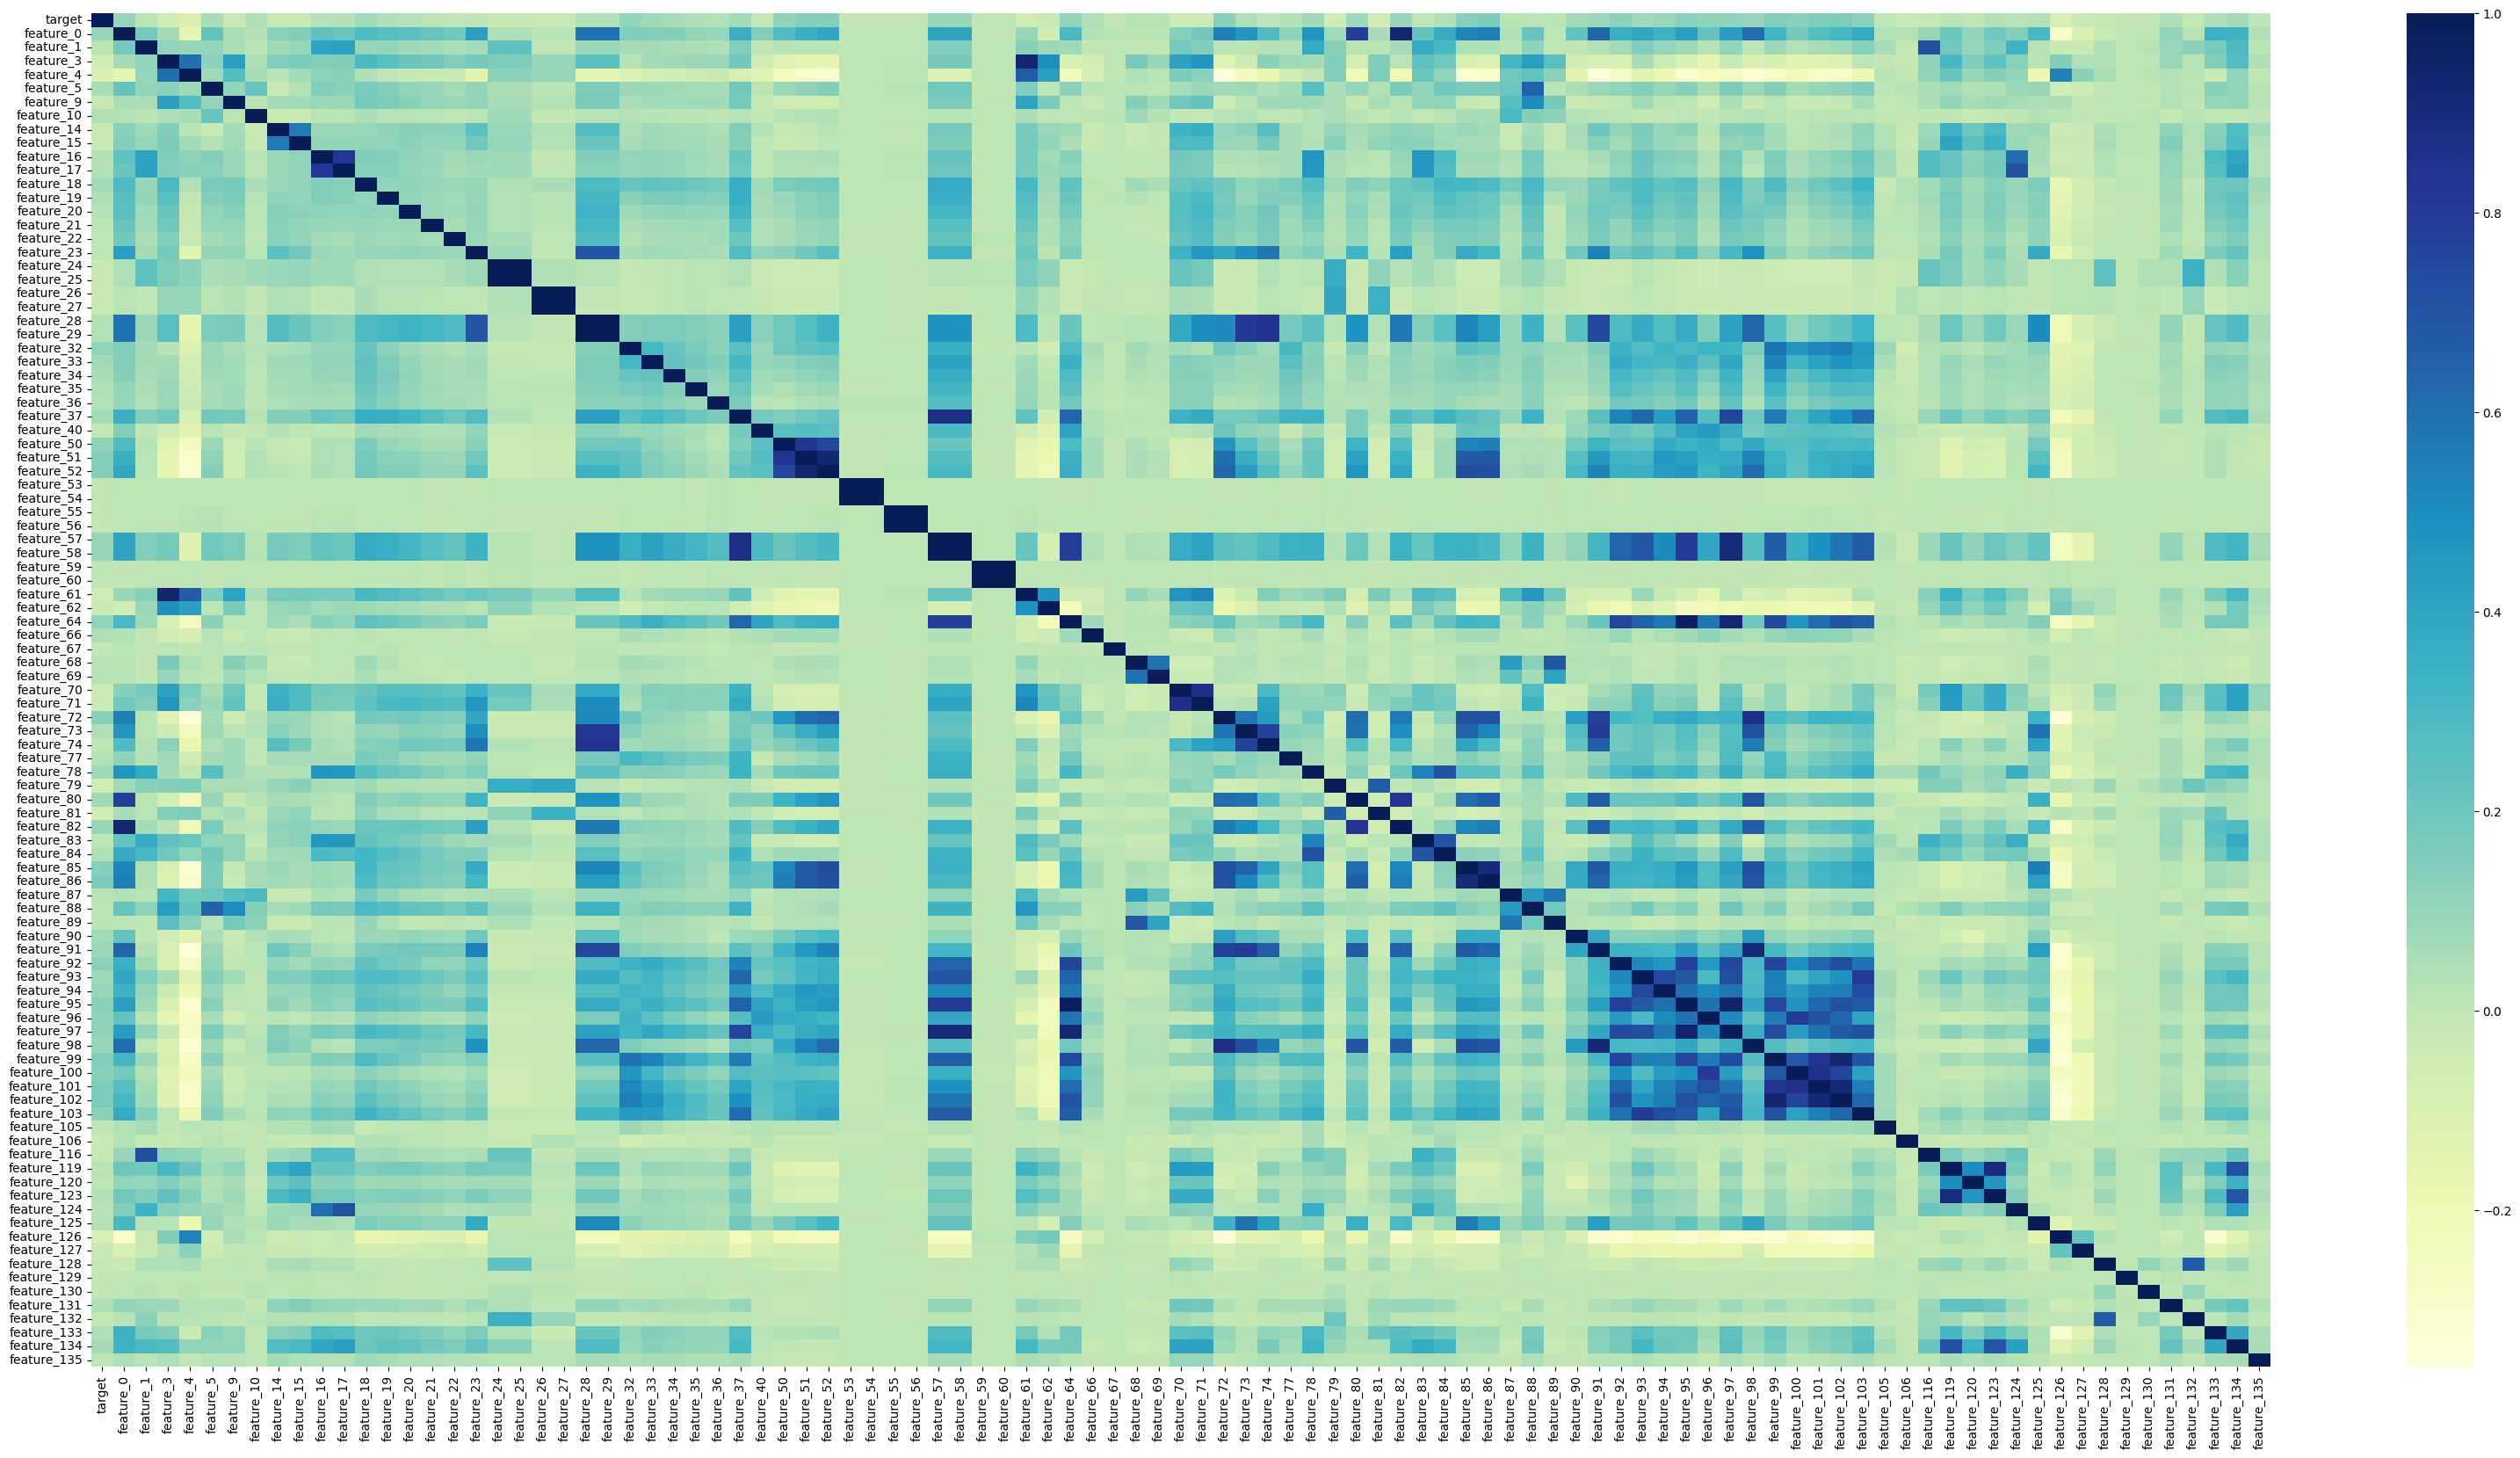

In [20]:
# df = df.drop(columns=to_drop)
corr_matrix = df.select_dtypes(exclude=['object']).corr()
plt.figure(figsize=(40, 20))

sns.heatmap(corr_matrix, cmap="YlGnBu")